In [1]:
from src.training.model import TransformerClassifier
import pandas as pd

from sklearn.model_selection import train_test_split
from src.utils import load_config

In [2]:
# Load config
env = "prod"
model_type = "BERT"

training_config = load_config(
    file_name="training_config", env=env, folder="../../config"
)

# Load the data

In [3]:
df = pd.read_parquet("../../output_data/prod/supervised_dataset.parquet")

In [11]:
X = df[[training_config.training[model_type].features, training_config.training[model_type].target]]

In [12]:
num_labels = X["label"].nunique()

# Split the data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    # X.drop(columns=[training_config.training[model_type].target]),
    X[training_config.training[model_type].features],
    X[training_config.training[model_type].target],
    test_size=training_config.training[model_type].test_size,
    random_state=training_config.training.random_state,
    stratify=X[training_config.training[model_type].target],
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=training_config.training[model_type].val_size,
    random_state=training_config.training.random_state,
    stratify=y_train,
)
X_test, X_cp, y_test, y_cp = train_test_split(
    X_test,
    y_test,
    test_size=training_config.training[model_type].cp_size,
    random_state=training_config.training.random_state,
    stratify=y_test,
)

KeyError: 'processed_text_to_analyse'

In [ ]:
# Upsample the minority class
from sklearn.utils import resample

X_upsampled = X_train.copy().to_frame()
X_upsampled[training_config.training[model_type].target] = y_train

# Separate majority and minority classes
df_majority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 0]
df_minority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=df_majority.shape[0],
    random_state=42,
)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
X_train = df_upsampled[training_config.training[model_type].features]
y_train = df_upsampled[training_config.training[model_type].target]

# Train the model

In [14]:
clf = TransformerClassifier(
    model_name="dtorber/bert-base-spanish-wwm-cased_K4",
    num_labels=num_labels,
)

In [15]:
clf = clf.fit(
    X=X_train,
    y=y_train,
    eval_X=X_val,
    eval_y=y_val,
    learning_rate=2e-5,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    early_stopping_patience=2,
    # freeze_layers_prefix=["bert.embeddings", "bert.encoder"],
    # freeze_layers_prefix=["bert.embeddings"] + [f"bert.encoder.layer.{i}" for i in range(1, 9)],
)

Epoch,Training Loss,Validation Loss
1,0.261400,0.294519
2,0.202100,0.233575
3,0.142900,0.172700
4,0.095300,0.264845
5,0.023300,0.273213


# Save the model

In [16]:
clf.model.save_pretrained("../../output_models/prod/model_rawdata_1")
clf.tokenizer.save_pretrained("../../output_models/prod/model_rawdata_1")

('../../output_models/prod/model_rawdata_1\\tokenizer_config.json',
 '../../output_models/prod/model_rawdata_1\\special_tokens_map.json',
 '../../output_models/prod/model_rawdata_1\\vocab.txt',
 '../../output_models/prod/model_rawdata_1\\added_tokens.json',
 '../../output_models/prod/model_rawdata_1\\tokenizer.json')

# Evaluate the model

In [17]:
clf = TransformerClassifier(
    model_name=None,
    num_labels=num_labels,
    local_model_path="../../output_models/prod/model_rawdata_1",
)

In [18]:
# Evaluate the model
from sklearn.metrics import classification_report

val_texts_list = X_test.tolist()  # Convert to a list if necessary
predictions = clf.predict(val_texts_list)

In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90        97
           1       0.86      0.88      0.87        77

    accuracy                           0.89       174
   macro avg       0.88      0.88      0.88       174
weighted avg       0.89      0.89      0.89       174



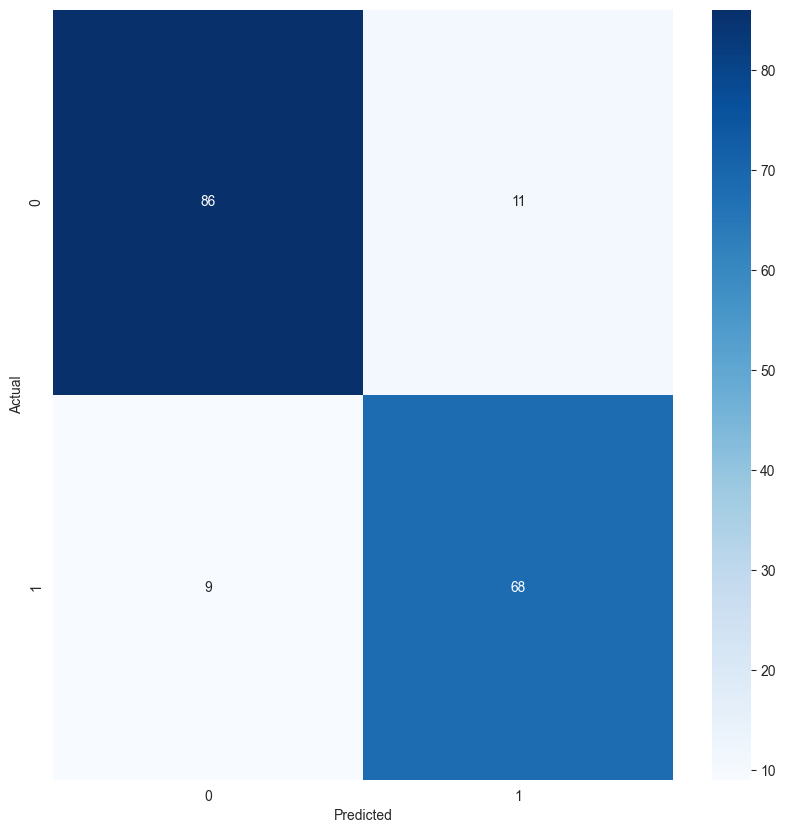

In [20]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()